### Imports

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse_metric
from itertools import product
import matplotlib.pyplot as plt

In [2]:
data_directory = '../data/experiment_verysmall/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (1, 2, 0))
data.shape

(2, 2801, 2)

In [3]:
data_train = data[:,:-3*365,:]
data_val = data[:,-3*365:-365,:]
data_test = data[:,-365:,:]

### data slicing

In [4]:
def data_slice(data, h, f):
    T = h + f
    samples = np.array([data[:,t:t + T,:] for t in range(len(data[0]) - T + 1)])
    return samples[:, :, :h, :], samples[:, : , h:, :]

def get_mse(forecast, true_vals):
    N, f , _ = forecast.shape
    forecast = forecast.reshape(N, f * 2)
    true_vals = true_vals.reshape(N, f * 2)
    
    return mse_metric(forecast, true_vals)

### gradboost forecaster

In [5]:
def fit_gbst_forecaster(hist_samples, future_samples, params):
    m, N, h, _ = hist_samples.shape
    _, _, f, _ = future_samples.shape
    
    hist_sample_matrix = hist_samples.reshape(m * N, h * 2)
    future_sample_matrix = future_samples.reshape(m * N, f * 2)
    gbst = xgb.XGBRegressor(max_depth = params['max_depth'], min_child_weight = params['min_child_weight'],
                            learning_rate = params['learning_rate'])
    gbst.fit(hist_sample_matrix, future_sample_matrix)
    return gbst

def get_gbst_forecast(gbst_model, history, f):
    N, h, _ = history.shape
    history = history.reshape(N, 2 * h)

    forecast = gbst_model.predict(history)
    return forecast.reshape(N,f,2)

In [6]:
def gbst_diff_val_exp(data_train, data_val, params):
    h = params['h']
    f = params['f']
    model_params = params['model_params']
    data_train_diff = np.diff(data_train, axis = 1)
    data_val_diff = np.diff(data_val, axis = 1)
    

    hist_train_samples_diff, future_train_samples_diff = data_slice(data_train_diff, h, f)
    hist_val_samples_diff, future_val_samples_diff= data_slice(data_val_diff, h, f)

    hist_train_samples, future_train_samples = data_slice(data_train, h, f)
    hist_val_samples, future_val_samples= data_slice(data_val, h, f)

    gbst_diff = fit_gbst_forecaster(hist_train_samples_diff, future_train_samples_diff, model_params)
    forecasts_diff = np.array([get_gbst_forecast(gbst_diff, hist, f) for hist in hist_val_samples_diff])
    forecasts_change = np.cumsum(forecasts_diff, axis = 2)

    hist_holds = np.array([np.repeat(hist[:,np.newaxis, -1,:], axis = 1, repeats = f) for hist in hist_val_samples])

    forecasts = hist_holds[:-1] + forecasts_change

    mses = np.array([get_mse(forecasts[i], future_val_samples[i]) for i in range(len(future_val_samples)-1)])
    return np.mean(mses)

In [7]:
h, f = 5, 7
model_params = {'max_depth':6, 'min_child_weight':0, 'learning_rate':0.07}
params = {'f':f, 'h':h, 'model_params':model_params}

In [8]:
rmse = np.sqrt(gbst_diff_val_exp(data_train, data_val, params))
rmse

5.7099325293364265

#### hyperparam tuning

In [11]:
def gbst_hyperparam_search(data_train, data_val, param_space):

    param_combinations = list(product(
        param_space["max_depth"],
        param_space["learning_rate"],
        param_space["min_child_weight"],
        param_space["h"],
        param_space["f"]
    ))

    num_comb = len(param_combinations)

    best_params = None
    best_score = float("inf")
    for i, combination in enumerate(param_combinations):
        
        model_params = {
            "max_depth": combination[0],
            "learning_rate": combination[1],
            "min_child_weight": combination[2], 
        }
        h = combination[3] 
        f = combination[4]
        params = {'f':f, 'h':h, 'model_params':model_params}
        
        rmse = np.sqrt(gbst_diff_val_exp(data_train, data_val, params))
        if (i+1) % 5 == 0:
            print(f'progress: {i+1}/{num_comb}')
        if rmse < best_score:
            best_params = params
            best_score = rmse
 
    return best_score, best_params

In [15]:
## found via co-ordinate wise descent. good, but not guaranteed optimal
param_grid = {
    "max_depth": np.arange(1,4),
    "learning_rate": [0.45],
    "min_child_weight": [0],
    "h": np.arange(8,15),
    "f": [7], 
}

In [16]:
best_mse, best_params = gbst_hyperparam_search(data_train, data_val, param_grid)

progress: 5/21
progress: 10/21
progress: 15/21
progress: 20/21


In [17]:
print(best_mse)
best_params

5.384237230223881


{'f': 7,
 'h': 9,
 'model_params': {'max_depth': 1,
  'learning_rate': 0.45,
  'min_child_weight': 0}}

### single example

In [10]:
h, f = 7, 3
hist_train, future_train = data_slice(data_train, h = h, f = f)
hist_val, future_val = data_slice(data_val, h = h, f = f)
hist_test, future_test = data_slice(data_test, h = h, f = f)

In [13]:
h, f = 20, 3
model_params = {'max_depth':6, 'min_child_weight':1, 'learning_rate':1}
params = {'f':f, 'h':h, 'model_params':model_params}
mse = gbst_val_exp(hist_train, future_train, hist_val, future_val, params)
print(mse)

42.122551908979176


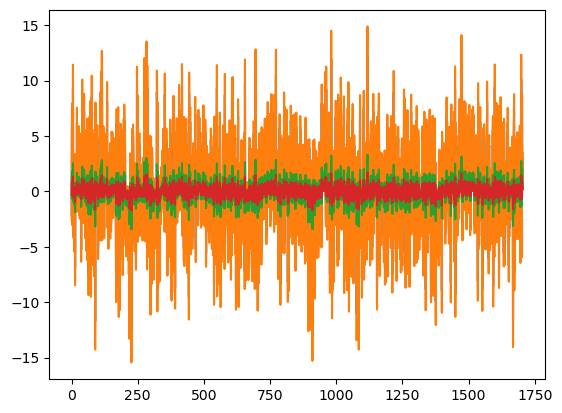

In [119]:
plt.plot(np.diff(data_train[:,:,1]).T)